# Variable과 AUTOGRAD
## PyTorch에서 Tensor와 Variabel의 차이
Variabel은 최근 파이토치 버전에서 삭제된 개념으로, 기존에 `autograd`를 사용하기 위해 사용되던 타입이었으나, 현재는 `Tensor` 타입과 병합  
-> `Tensor` 타입에서 디폴트로 `autograd` 기능을 지원하도록 변경됨

## TORCH.AUTOGRAD
`torch.autograd`는 신경망 학습을 지원하는 PyTorch의 자동 미분 엔진  

## Autograd & Variable
`Autograd`는 자동 미분을 수행하는 파이토치의 핵심 패키지로, 자동 미문을 위해 테잎(tape) 기반 시스템을 사용  
순전파(forward) 단계에서 `autograd` 테잎은 수행하는 모든 연산을 기억하고, 역전파(backward) 단계에서 연산들을 재생(replay)  
자동 계산을 위해 사용하는 변수들은 `torch.autograd.Variable`를 사용해야 함

In [3]:
import torch
from torch.autograd import Variable

a = torch.rand(5)
a = Variable(a)

In [4]:
a

tensor([0.3861, 0.8243, 0.2681, 0.1612, 0.5620])

`Variable`은 `data, grad, grad_fn` 3가지 형태로 이뤄짐  
- `data`: 텐서 형태의 데이터
- `grad`: `data`가 거쳐온 layer에 대한 축적된 미분값
- `grad_fn`: 미분값을 계산한 함수의 정보

## 배경(Background)
### 신경망(NN: Neural Network)
신경망은 **어떤 입력 데이터에 대해 실행되는 중첩(nested)된 함수들의 모음(collection)** 으로, `Tensor`로 저장되는 **가중치(weight)와 편향(bias)** 으로 구성된 매개변수들로 정의  
#### 신경망 학습 단계
1. 순전파(Forward Propagation)
2. 역전파(Backward Propagation)

순전파 단계에서는, 신경망은 정답을 맞추기 위해 최선을 추측(best guess)을 함  
추측을 하기 위해서 입력 데이터를 각 함수들에서 실행  

역전파 단계에서는, 신경망은 추측한 값에서 발생한 오류(error)에 비례하여(proportionate) 매겨변수들을 적절히 조절  
출력(output)으로부터 역방향으로 이동하면서 오류에 대한 함수들의 매개변수들의 미분값(**변화도(gradient)**)을 수집하고, 경사하강법(gradient descnet)을 사용해 매개변수들을 최적화

## PyTorch에서 사용법

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch, torchvision
model = torchvision.models.resnet18(pretrained=True)
data = torch.rand(1, 3, 64, 64) # 3채널 64 by 64 이미지를 표현하는 무작위 데이터 텐서
labels = torch.rand(1, 1000) # 데이터에 상응하는 무작위 정답 레이블

In [6]:
# 순전파 단계
prediction = model(data)

In [7]:
# 역전파 단계
loss = (prediction - labels).sum()
loss.backward()

In [8]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

In [18]:
# 경사하강법(gradient descent)
optim.step()

#### 모멘텀(Momentum)
- 학습 방향을 유지하려는 성질 -> 이전 학습 방향을 유지하려는 성질
  - 학습 방향이 바로 바뀌지 않고, 일정한 방향을 유지하며 움직임
  - 같은 방향의 학습이 진행되면 가속을 가지며 더 빠른 학습을 기대할 수 있음

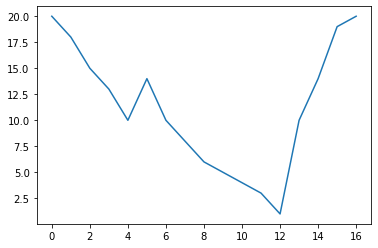

In [17]:
import matplotlib.pyplot as plt

y_val = [20, 18, 15, 13, 10, 14, 10, 8, 6, 5, 4, 3, 1, 10, 14, 19, 20]
x_val = range(0, len(y_val))
plt.plot(x_val, y_val)
plt.show()

처음 등장하는 작은 언덕은 지역 최소값(Local Minimum)이고, 이후에 등장하는 큰 언덕은 전역 최소값(Global Minimum)  

첫 부분에서 공을 굴렸다고 가정하면, 운동량이 부족해 최종 목적지에 도달하지 못하고 속도가 떨어져 작은 언덕(지역 최소값)에서 멈추게 됨  
모멘텀을 고려하지 않은 방법으로, 작은 언덕에 빠질 가능성이 있는 알고리즘  

알고리즘에 운동량을 추가하는 방법이 모멘텀을 고려하는 방식  
이전 업데이트 단계에 계수에 곱하는 수식의 경우, 현재 업데이트와 이전 업데이트에 동일한 중요치를 할당

## Autograd에서 미분(differentiation)
`autograd`가 변화도(gradient)를 수집하는 방법  
`requires_grad=True`는 모든 연산들을 추적해야한다는 것을 명시

In [19]:
import torch

a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

$Q = 3a^3 - b^2$

In [20]:
Q = 3*a**3 - b**2

a와 b가 모두 신경망(NN)의 매개변수이고, Q가 오차(error)라고 가정  
신경망을 학습할 때, 아래와 같이 매개변수들에 대한 오차의 변화(gradient)를 구함

${\partial Q \over \partial a} = 9a^2$  

${\partial Q \over \partial b} = -2b$  

Q에 대해서 `.backward()`를 호출할 때, autograd는 이러한 변화도들을 계산하고 이를 각 텐서의 `.grad` 속성에 저장  
Q는 벡터이므로 `Q.backward()`에 `gradient` 인자(argument)를 명시적으로 전달해야 함

In [21]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)

In [22]:
# 변화도
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


## 선택적으로 읽기(Optional Reading) - autograd를 사용한 벡터 미적분
수학적으로, 벡터 함수 $\vec y = f(\vec x)$에서 $\vec x$에 대한 $\vec y$의 변화도는 야코비안 행렬(Jacobian Matrix): J임  


일반적으로 `torch.autograd`는 벡터-야코비안 곱을 계산하는 엔진  
-> 주어진 어떤 벡터 $\vec v$에 대해 $J^T \cdot \vec v$을 연산  

만약 $\vec v$가 스칼라 함수 $l = g(\vec y)$의 변화도(gradient)인 경우, 연쇄 법칙(chain rule)에 따라 벡터-야코비안 곱은 $\vec x$에 대한 $l$의 변화도(gradient)가 됨  

위 예제에서는 이러한 개념을 사용했고, `external_grad`가 $\vec v$를 의미함

## 연산 그래프(Computational Graph)
개념적으로, autograd는 데이터(텐서) 및 실행된 모든 연산들의 기록을 방향성 비순환 그래프(DAG: Directed Acyclic Graph)에 저장  

이 방향성 비순환 그래프의 잎(leave)은 입력 텐서, 뿌리(root)는 결과 텐서이므로, 뿌리에서 잎까지 추적하면 연쇄 법칙에 따라 변화도를 자동으로 계산할 수 있음

순전파 단계에서, `autograd`는 다음 두가지 작업을 동시에 수행  
1. 요청된 연산을 수행하여 결과 텐서를 계산
2. DAG에 연산의 변화도 기능(gradient function)를 유지(maintain)

역전파 단계는 DAG 뿌리에서 `.backward()`가 호출될 때 시작되며, `autograd`는 다음 작업을 수행  
1. 각 `.grad_fn`으로부터 변화도를 계산
2. 각 텐서의 `.grad` 속성에 계산 결과를 쌓고(accumulate)
3. 연쇄 법칙을 사용해, 모든 잎(leaf) 텐서들까지 전파(propagate)

## DAG에서 제외하기
`torch.autograd`는 `requires_grad` 플래그가 `True`로 설정된 모든 텐서에 대한 연산들을 추적하므로, 변화도가 필요하지 않은 텐서들에 대해서는 해당 속성을 `False`로 설정해 DAG 변화도 계산에서 제외  
입력 텐서 중 단 한개라고 추적이 허용되면 연산의 결과 텐서도 변화도를 갖게 됨

In [24]:
x = torch.rand(5, 5)
y = torch.rand(5, 5)
z = torch.rand((5, 5), requires_grad=True)

a = x + y
print(f"Does `a` require gradients? : {a.requires_grad}")
b = x + z
print(f"Does `b` require gradients? : {b.requires_grad}")

Does `a` require gradients? : False
Does `b` require gradients? : True


신경망에서, 변화도를 계산하지 않는 매개변수를 일반적으로 **고정된 매개변수(frozen parameter)** 라고 부름  
이러한 매개변수의 변화도가 필요하지 않다는 것을 미리 알고 있으면, 모델의 일부를 고정(freeze)하는 것이 유용함  
-> `autograd`의 연산량을 줄임으로써 성능 상의 이득을 제공

DAG에서 제외하는 것이 중요한 또 다른 일반적인 사례는 **미리 학습된 모델을 미세조정** 하는 경우  
미세조정(finetuning)을 하는 과정에서, 새로운 정답(label)을 예측할 수 있도록 모델의 대부분을 고정한 뒤 일반적으로 분류 계층(classifier layer)만 변경

In [25]:
from torch import nn, optim

model = torchvision.models.resnet18(pretrained=True)
# 신경망의 모든 매개변수를 고정
for param in model.parameters():
    param.requires_grad = False

10개의 정답을 갖는 새로운 데이터셋으로 모델을 미세조정하는 상황을 가정  
resnet에서 분류기는 마지막 선형 계층인 `model.fc`임, 이를 새로운 분류기로 동작할 (고정되지 않은) 새로운 선형 계층으로 간단히 대체

In [26]:
model.fc = nn.Linear(512, 10)

`model.fc`를 제외한 모델의 모든 매개변수들이 고정됨  
-> 변화도를 계산하는 유일한 매개변수는 `model.fc`의 가중치와 편향뿐임

In [27]:
# 분류기만 최적화
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

옵티마이저에 모든 매개변수를 등록하더라도, 변화도를 계산하고 경사하강법으로 갱신할 수 있는 매개변수들은 분류기의 가중치와 편향뿐임

## 스터디
`Tensor`는 훈련용 데이터로 사용함 -> 그라디언트를 계산할 필요가 없기에  
`Variable(Tensor(requires_grad=True))`는 파라미터를 업데이틀 할 목적으로 사용